In [1]:
import sys
sys.path.insert(0, "..")

import random
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pyro
import foraging_toolkit as ft
import torch.nn.functional as F
import pyro.distributions as dist
import pyro.optim as optim
from pyro.nn import PyroModule
from pyro.infer.autoguide import AutoNormal, AutoDiagonalNormal, AutoMultivariateNormal, init_to_mean, init_to_value
from pyro.contrib.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import Predictive
from pyro.infer import MCMC, NUTS

import os
import logging
logging.basicConfig(format='%(message)s', level=logging.INFO)
smoke_test = ('CI' in os.environ)


import foraging_toolkit as ft

## Random birds

### Running a simulation

In [2]:
random.seed(2)
np.random.seed(2)
# generate a simulation object with fixed 
# simulation parameters
random_birds_sim = ft.RandomBirds(grid_size= 40,
                        probabilities= [1, 2, 3, 2, 1, 2, 3, 2, 1],
                        num_birds= 3,
                        num_frames= 10,
                        num_rewards= 15,
                        grab_range= 3)

#run a particular simulation with these parameters
random_birds_sim()
print(random_birds_sim.birds[0])

print(len(random_birds_sim.birds))

      x     y  time  bird    type
0  19.0  21.0     1     1  random
1  15.0  21.0     2     1  random
2  16.0  18.0     3     1  random
3  15.0  18.0     4     1  random
4  14.0  16.0     5     1  random
5  12.0  18.0     6     1  random
6  10.0  21.0     7     1  random
7  11.0  21.0     8     1  random
8   9.0  24.0     9     1  random
9   7.0  21.0    10     1  random
3


In [3]:
print(random_birds_sim.birds[0].shape[0])

10


In [4]:
# you have created birds and rewards in a space-time grid

#each row contains the x and y coordinates of a bird at a particular time
random_birds_sim.birdsDF.head()

,x,y,time,bird,type
0,19.0,21.0,1,1,random
1,15.0,21.0,2,1,random
2,16.0,18.0,3,1,random
3,15.0,18.0,4,1,random
4,14.0,16.0,5,1,random


In [5]:
# each row contains the x and y coordinates of a reward at a particular time
random_birds_sim.rewardsDF.head()

,x,y,time
0,38,16,1
1,11,31,1
2,9,14,1
3,27,27,1
4,36,40,1


In [6]:
# look at just the birds

ft.animate_birds(random_birds_sim, plot_rewards=True,
                  width = 600, height = 600, point_size = 10)


### Derived predictors

In [7]:
# let's add derived predictors to the simulation object

random_birds_derived = ft.derive_predictors(random_birds_sim)

In [8]:
# now we can plot food traces in time:

ft.animate_birds(random_birds_derived, plot_rewards=True, width = 600,
                  height = 600, point_size = 10,plot_traces=True)

In [9]:
# we can also plot visibility, for one bird at a time
# as multiple birds' visibility is hard to see 
# let's say, bird 2

ft.animate_birds(random_birds_derived, plot_rewards=True, width = 600,
                  height = 600, point_size = 10, 
                  plot_visibility=2, plot_traces=True)


In [10]:
# we can plot proximity score
# bird 2 again

ft.animate_birds(random_birds_derived, plot_rewards=True, width = 600,
                  height = 600, point_size = 10, plot_proximity=2)

### Inference


In [11]:
# prepare data

df = random_birds_derived.transformationsDF.dropna()

data = torch.tensor(df[["proximity_standardized",
                         "trace_standardized", 
                         "visibility", "how_far_squared_scaled"]].values, dtype=torch.float32)

proximity, trace, visibility, how_far = data[:, 0], data[:, 1], data[:, 2], data[:, 3]

In [12]:
# visualise key predictors:

ft.visualise_bird_predictors(trace, proximity, how_far)

In [13]:
#setting up the MCMC inference method

def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

def mcmc_training(model, num_samples, *args):
    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=num_samples//4)
    mcmc.run(*args)

    hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

    for site, values in summary(hmc_samples).items():
        if site in ["t","p"]:
            print("Site: {}".format(site))
            print(values, "\n")

    return hmc_samples

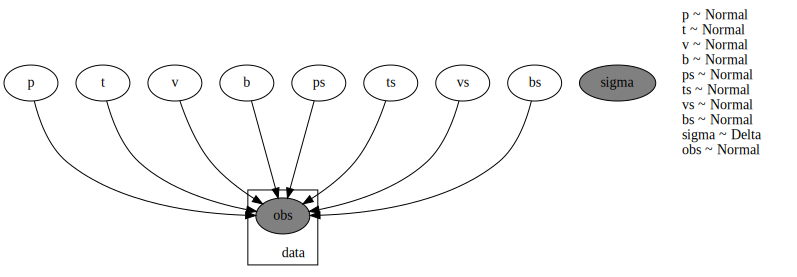

In [16]:
# define the model
# p, t, v, b are the coefficients 
# for proximity, trace, visibility, and the intercept

# ps, ts, vs, bs are analogous coefficients,
# but they contribute to the variance,
# which is not assumed to remain fixed


def model_sigmavar(prox, tr, vis, hf):
    p = pyro.sample("p", dist.Normal(0, .3))
    t = pyro.sample("t", dist.Normal(0, .3))
    v = pyro.sample("v", dist.Normal(0, .3))
    b = pyro.sample("b", dist.Normal(.5, .3))

    ps = pyro.sample("ps", dist.Normal(0, .3))
    ts = pyro.sample("ts", dist.Normal(0, .3))
    vs = pyro.sample("vs", dist.Normal(0, .3))
    bs = pyro.sample("bs", dist.Normal(.2, .3))


    sigmaRaw = bs + ps * prox + ts * tr + vs * vis
    sigma = pyro.deterministic("sigma", F.softplus(sigmaRaw))
    mean = b + p * prox + t * tr + v * vis

    with pyro.plate("data", len(hf)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=hf)

pyro.render_model(model_sigmavar, model_args=(proximity, trace, visibility, how_far),
                        render_distributions=True)

In [17]:
# Inference with SVI
# note how long this takes
# and compare with MCM 

guide = AutoMultivariateNormal(model_sigmavar, init_loc_fn=init_to_mean)
svi = SVI(model_sigmavar,
        guide,
        optim.Adam({"lr": .01}),
        loss=Trace_ELBO())

iterations = []
losses = []

pyro.clear_param_store()
num_iters = 1000
for i in range(num_iters):
    elbo = svi.step(proximity, trace, visibility, how_far)
    iterations.append(i)
    losses.append(elbo)
    if i % 200 == 0:
        logging.info("Elbo loss: {}".format(elbo))


Elbo loss: 5868.026113390923


Elbo loss: -4981.976088941097
Elbo loss: -9313.186646938324
Elbo loss: -9783.100775301456
Elbo loss: -9401.501142859459


In [17]:
df = pd.DataFrame({'iterations': iterations, 'ELBO Loss': losses})

fig = px.line(df, x='iterations', y='ELBO Loss')

fig.update_layout(
    title="ELBO Loss over iterations",
    xaxis_title="iterations",
    yaxis_title="ELBO Loss",
    template="plotly_dark", 
    showlegend=False,  
    xaxis_showgrid=False,
    yaxis_showgrid=False,
)

fig.show()

In [18]:
# inspect the summary of the SVI posterior
# of key interest: t and p

num_samples = 1000
predictive = Predictive(model_sigmavar, guide=guide, 
                        num_samples=num_samples,
                        return_sites = ["t", "p"])
random_sigmavar = {k: v.flatten().reshape(num_samples, -1).detach().cpu().numpy()
            for k, v in predictive(proximity, trace, visibility, how_far).items()
            if k != "obs"}

for site, values in summary(random_sigmavar).items():
            print("Site: {}".format(site))
            print(values, "\n")

Site: p
       mean       std        5%       25%       50%       75%       95%
0 -0.000189  0.004933 -0.008584 -0.003663  0.000015  0.003224  0.007657 

Site: t
       mean       std        5%       25%       50%       75%       95%
0 -0.011334  0.005763 -0.020609 -0.015286 -0.011213 -0.007537 -0.001651 



In [19]:
# as a sanity check
# compare with the results 
# from the MCMC method

# warning: MCMC training might take a bit of time to run if num_samples is large
random_sigmavar_mcmc = mcmc_training(model_sigmavar, 1000, proximity, trace, visibility, how_far)

Sample: 100%|██████████| 1250/1250 [01:56, 10.77it/s, step size=8.16e-02, acc. prob=0.903]

Site: p
       mean       std        5%       25%       50%       75%       95%
0  0.000813  0.000809 -0.000522  0.000275  0.000811  0.001391  0.002096 

Site: t
       mean       std        5%       25%       50%       75%       95%
0 -0.006704  0.000944 -0.008285 -0.007323 -0.006675 -0.006057 -0.005182 



In [20]:
site_p_svi = random_sigmavar['p'].flatten().tolist()
site_t_svi = random_sigmavar['t'].flatten().tolist()
site_p_mcmc = random_sigmavar_mcmc['p'].flatten().tolist()
site_t_mcmc = random_sigmavar_mcmc['t'].flatten().tolist()

source_svi = ['svi'] * len(site_p_svi)
source_mcmc = ['mcmc'] * len(site_p_mcmc)

data = {
    'p': site_p_svi +  site_p_mcmc,
    't': site_t_svi +  site_t_mcmc,
    'inference_method': source_svi  + source_mcmc
}

df = pd.DataFrame(data)

fig = px.scatter(df, x='p', y='t', color='inference_method', 
                title='Random birds (posterior densities)',
                template='plotly_dark')

fig.update_xaxes(range=[-.03, .03])
fig.update_yaxes(range=[-.03, .03])

fig.update_layout(autosize=False,
        width=600,
        height=600
)

fig.update_traces(marker=dict(size=3.5, opacity=0.4))

fig.show()